## Experiments for Bayes by Hypernet on MNIST

In [1]:
# import stuff
from __future__ import division, print_function

import os

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import numpy as np
from tqdm import trange
# read mnist data
data = input_data.read_data_sets('mnist') # put data path here
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
# function to get network dependent on mode (inference method)
def get_net(mode, ops):
    with tf.variable_scope('net'):
        x = tf.placeholder(tf.float32, [None, 784])
        y = tf.placeholder(tf.int32, [None])
        
        ops['x'] = x
        ops['y'] = y
        
        if mode == 'implicit': # ours
            g1 = ops['g1']
            g2 = ops['g2']
            g3 = ops['g3']
            
            # layer 1
            v1 = tf.get_variable('v1', [784, 800], tf.float32,
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v1)
            
            b1 = tf.get_variable('b1', [800], tf.float32, tf.constant_initializer())
            
            scaler = g1 / tf.sqrt(tf.reduce_sum(tf.square(v1),[0]))
            x = tf.reshape(scaler,[1, 800])*x + tf.reshape(b1, [1, 800])
            x = tf.nn.relu(x)
            
            # layer 2
            v2 = tf.get_variable('v2', [800, 800], tf.float32,
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v2)
            
            b2 = tf.get_variable('b2', [800], tf.float32, tf.constant_initializer())
            
            scaler = g2 / tf.sqrt(tf.reduce_sum(tf.square(v2),[0]))
            x = tf.reshape(scaler,[1, 800])*x + tf.reshape(b2, [1, 800])
            x = tf.nn.relu(x)
            
            # layer 3
            v3 = tf.get_variable('v3', [800, 10], tf.float32,
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v3)
            
            b3 = tf.get_variable('b3', [10], tf.float32, tf.constant_initializer())
            
            scaler = g3 / tf.sqrt(tf.reduce_sum(tf.square(v3),[0]))
            x = tf.reshape(scaler,[1, 10])*x + tf.reshape(b3, [1, 10])
        elif mode == 'bbb': # bayes by backprop
            
            # layer 1
            w1_loc = tf.get_variable('w1_loc', [784, 800], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            w1_log_scale_sq = tf.get_variable('w1_log_scale_sq', [784, 800], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            w1 = tf.random_normal((784, 800)) * tf.sqrt(tf.exp(w1_log_scale_sq)) + w1_loc
            
            b1_loc = tf.get_variable('b1_loc', [800], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            b1_log_scale_sq = tf.get_variable('b1_log_scale_sq', [800], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            b1 = tf.random_normal((800,)) * tf.sqrt(tf.exp(b1_log_scale_sq)) + b1_loc
            
            x = tf.matmul(x, w1) + tf.reshape(b1, [1, 800])
            x = tf.nn.relu(x)
            
            # layer 2
            w2_loc = tf.get_variable('w2_loc', [800, 800], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            w2_log_scale_sq = tf.get_variable('w2_log_scale_sq', [800, 800], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            w2 = tf.random_normal((800, 800)) * tf.sqrt(tf.exp(w2_log_scale_sq)) + w2_loc
            
            b2_loc = tf.get_variable('b2_loc', [800], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            b2_log_scale_sq = tf.get_variable('b2_log_scale_sq', [800], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            b2 = tf.random_normal((800,)) * tf.sqrt(tf.exp(b2_log_scale_sq)) + b2_loc
            
            
            
            x = tf.matmul(x, w2) + tf.reshape(b2, [1, 800])
            x = tf.nn.relu(x)
            
            # layer 3
            w3_loc = tf.get_variable('w3_loc', [800, 10], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            w3_log_scale_sq = tf.get_variable('w3_log_scale_sq', [800, 10], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            w3 = tf.random_normal((800, 10)) * tf.sqrt(tf.exp(w3_log_scale_sq)) + w3_loc
            
            b3_loc = tf.get_variable('b3_loc', [10], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            b3_log_scale_sq = tf.get_variable('b3_log_scale_sq', [10], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            b3 = tf.random_normal((10,)) * tf.sqrt(tf.exp(b3_log_scale_sq)) + b3_loc
            
            x = tf.matmul(x, w3) + tf.reshape(b3, [1, 10])
            
            kl_loss = tf.add_n([tf.reduce_sum(1 + scale - tf.square(loc) - tf.exp(scale)) for loc, scale in
                                [(w1_loc, w1_log_scale_sq), (b1_loc, b1_log_scale_sq), (w2_loc, w2_log_scale_sq),
                                (b2_loc, b2_log_scale_sq), (w3_loc, w3_log_scale_sq), (b3_loc, b3_log_scale_sq)]])
            
                       
            ops['kl_loss'] = - 0.5 * kl_loss / 6
            
        elif mode == 'dropout': # dropout
            x = tf.layers.dense(inputs=x, units=800, activation=tf.nn.relu)
            x = tf.nn.dropout(x, 0.7)

            x = tf.layers.dense(inputs=x, units=800, activation=tf.nn.relu)
            x = tf.nn.dropout(x, 0.7)

            # Second fully connected layer, reducing to num_classes
            x = tf.layers.dense(inputs=x, units=10) # [100 x 10]
        else: # maximum likelihood
            x = tf.layers.dense(inputs=x, units=800, activation=tf.nn.relu)

            x = tf.layers.dense(inputs=x, units=800, activation=tf.nn.relu)

            # Second fully connected layer, reducing to num_classes
            x = tf.layers.dense(inputs=x, units=10) # [100 x 10]

        ops['logits'] = x
        
        return ops
        
# hypernetwork to generate weights
def get_h_net(units=[64, 256], num_noise=29):
    with tf.variable_scope('h_net'):
        # auxiliary conditioning
        w1_c = tf.constant([1., 0., 0.])
        w2_c = tf.constant([0., 1., 0.])
        w3_c = tf.constant([0., 0., 1.])
        
        #auxiliary noise
        noise = tf.random_normal((num_noise, ))

        w1_z = tf.reshape(tf.concat([w1_c, noise], 0), (1, num_noise + 3))
        w2_z = tf.reshape(tf.concat([w2_c, noise], 0), (1, num_noise + 3))
        w3_z = tf.reshape(tf.concat([w3_c, noise], 0), (1, num_noise + 3))

        w_z = tf.concat([w1_z, w2_z, w3_z], 0)
        
        z = w_z
        
        for unit in units:
            z = tf.layers.dense(inputs=z, units=unit)
            z = tf.nn.relu(z)
        
        z = tf.layers.dense(inputs=w_z, units=800)

        w1 = z[0, :]
        w2 = z[1, :]
        w3 = z[2, :10]
        
        return [w1, w2, w3, tf.reshape(tf.concat([w1, w2, w3], 0), (1610, 1))]

def get_d_net(gens, units=[20, 20]):
    with tf.variable_scope('d_net'):
        
        ds = tf.contrib.distributions
        mix = 0.7
        bimix_gauss = ds.Mixture(
          cat=ds.Categorical(probs=[mix, 1.-mix]),
          components=[
            ds.Normal(loc=0., scale=0.01),
            ds.Normal(loc=0., scale=5.),
        ])
        
        noise = bimix_gauss.sample((800 + 800 + 10, 1))
        
        all_t = tf.concat((gens, noise), 0)
        
        d = all_t
        
        for unit in units:
            d = tf.layers.dense(inputs=d, units=unit )
            d = tf.nn.relu(d)
        
        d = tf.layers.dense(inputs=d, units=1)
        
        return d[:800 + 800 +10], d[800 + 800 +10:]

In [3]:
num_noise = 125

layers = [64, 256]

mode = 'implicit'

batch_size = 128

tf.reset_default_graph()

ops = {}
# if implicit get hypetnetwork generated weights
if mode == 'implicit':
    w1, w2, w3, gens = get_h_net(num_noise=num_noise, units=layers)

    g_d, n_d = get_d_net(gens)

    ops = {'g1': w1, 'g2': w2, 'g3': w3}

    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'd_net')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h_net')

# get network ops
ops = get_net(mode, ops)

net_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'net')

# build ce loss
ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ops['logits'], labels=ops['y']))

opt = tf.train.AdamOptimizer(0.001, epsilon=1e-5)

if mode == 'implicit':
    loss_d = (- tf.reduce_mean(tf.log(1 - tf.nn.sigmoid(n_d) + 1e-8, name='log_n_d'))
              - tf.reduce_mean(tf.log(tf.nn.sigmoid(g_d) + 1e-8, name='log_g_d')))

    gvs = opt.compute_gradients(loss_d, var_list=d_vars)
    capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs if grad is not None]
    d_optimiser = opt.apply_gradients(capped_gvs)

    g_logits_m = tf.reduce_mean(g_d)

    loss_g = g_logits_m + len(data.train.labels) / float(batch_size) * ce

    g_optimiser = opt.minimize(loss_g, var_list=g_vars+net_vars)

    d_n_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(n_d) < 0.5, tf.float32))
    d_g_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(g_d) >= 0.5, tf.float32))
elif mode == 'bbb':
    optimiser = opt.minimize(ce *  float(len(data.train.labels)) / float(batch_size) + ops['kl_loss'])
else:
    optimiser = opt.minimize(ce)

# build function to hold predictions
pred = tf.argmax(ops['logits'], -1, output_type=tf.int32)

# create tensor to calculate accuracy of predictions
acc = tf.reduce_mean(tf.cast(tf.equal(pred, ops['y']), tf.float32))

probs = tf.nn.softmax(ops['logits'])

# build op to initialise the variables
init = tf.global_variables_initializer()

numerics = tf.add_check_numerics_ops()

In [4]:
s = tf.Session()

# initialise the weights
s.run(init)

# run discriminator to give better gradients
if mode == 'implicit':
    for _ in range(300):
        s.run(d_optimiser)

with trange(50 * 390) as pbar: # run ~50 epochs
    for i in pbar:
        # get batch from dataset
        b = batch_xs, batch_ys = data.train.next_batch(128)

        if mode == 'implicit':
            # run discriminator to give better gradients
            for _ in range(20):
                s.run(d_optimiser)

            np_acc, d_loss, g_loss, l_loss, np_d, np_g, _, _ = s.run([acc, loss_d, g_logits_m, ce,
                                                                  d_n_acc, d_g_acc, g_optimiser, numerics],
                                                                 feed_dict={ops['x']: batch_xs,
                                                                            ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, d_loss=d_loss, g_loss=g_loss,
                             l_loss=l_loss, d_n_acc=np_d, d_g_acc=np_g)
        elif mode == 'bbb':
            np_acc, l_loss, kl_loss, _ = s.run([acc, ce, ops['kl_loss'], optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})
            pbar.set_postfix(acc=np_acc, ce=l_loss, kl_loss=kl_loss)
        else:
            np_acc, l_loss, _ = s.run([acc, ce, optimiser],
                                      feed_dict={ops['x']: batch_xs, ops['y']: batch_ys})

            pbar.set_postfix(acc=np_acc, ce=l_loss)

100%|██████████| 19500/19500 [12:14<00:00, 26.57it/s, acc=0.992, d_g_acc=0.956, d_loss=0.592, d_n_acc=0.826, g_loss=1.7, l_loss=0.0107] 


In [5]:
# calculate accuracy on test set
if mode == 'implicit' or mode == 'dropout' or mode == 'bbb':
    np_probs = np.zeros((len(data.test.labels), 10))
    mc_steps = 100
    for _ in trange(mc_steps):
        np_probs += s.run(probs, feed_dict={ops['x']: data.test.images})

    np_probs /= mc_steps
else:
    np_probs = s.run(probs, feed_dict={ops['x']: data.test.images})

np_preds = np.argmax(np_probs, -1)
np_test_acc = np.mean(np_preds == data.test.labels)
print('Test accuracy is {}'.format(np_test_acc))

100%|██████████| 100/100 [00:01<00:00, 98.08it/s]

Test accuracy is 0.983


In [6]:
test_img = data.test.images[18]

# test predictive uncertainty on a rotated image of the digit 3
def rotate(angle):
    img = scipy.ndimage.rotate(test_img.reshape((28, 28)), angle, reshape=False)
    return img.reshape((1, -1))

def predict(img):
    mc_steps = 100
    np_probs_raw = np.zeros((mc_steps, len(img), 10))
    for i in trange(mc_steps):
        np_probs_raw[i] = s.run(probs, feed_dict={ops['x']: img})

    np_probs = np.mean(np_probs_raw, 0)
    return np_probs, np_probs_raw

df = pd.DataFrame(columns=['prob', 'out', 'angle'])

for deg in range(10):
    p, r = predict(rotate(deg * 10))
    for n in range(10):
        new_df = pd.DataFrame(columns=['prob', 'out', 'angle'],
                              data=zip(r[:, 0, n], [n + 1] * len(r), [deg * 10] * len(r)))
        df = pd.concat([df, new_df])

100%|██████████| 100/100 [00:00<00:00, 2264.60it/s]


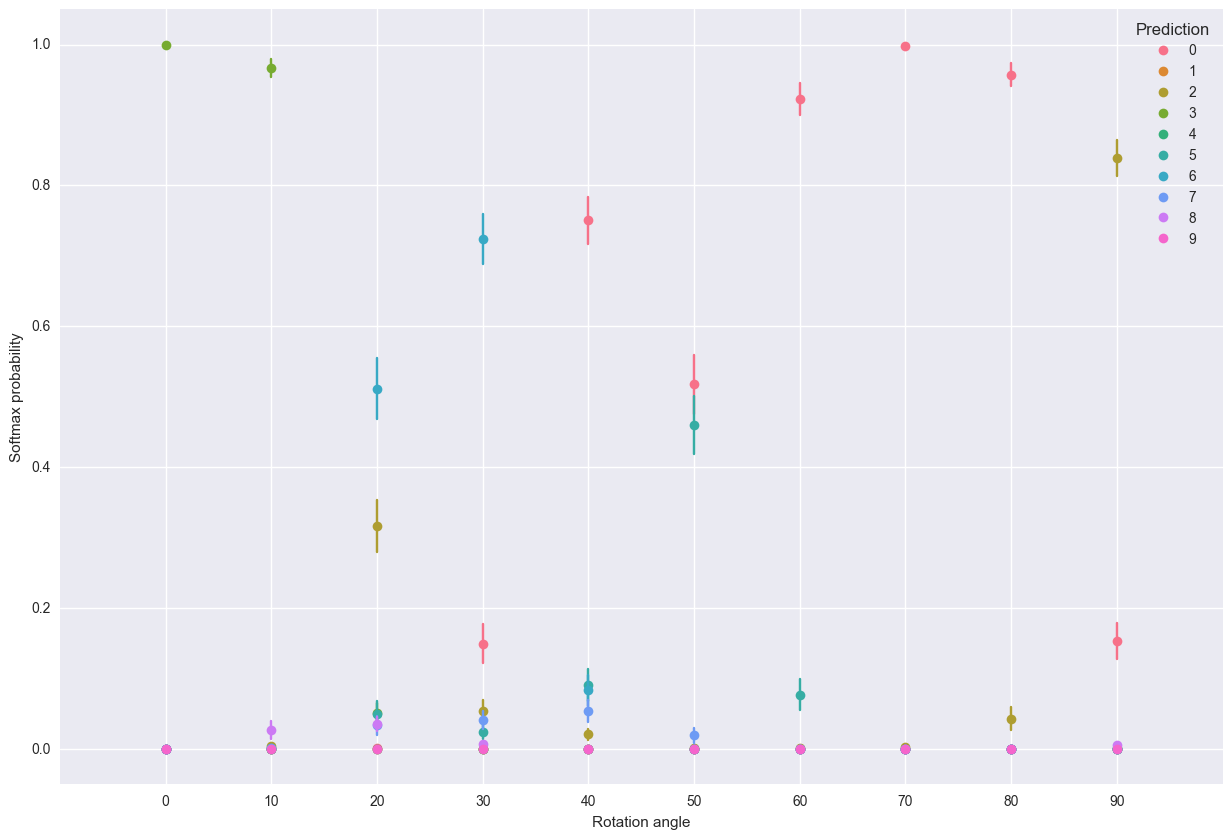

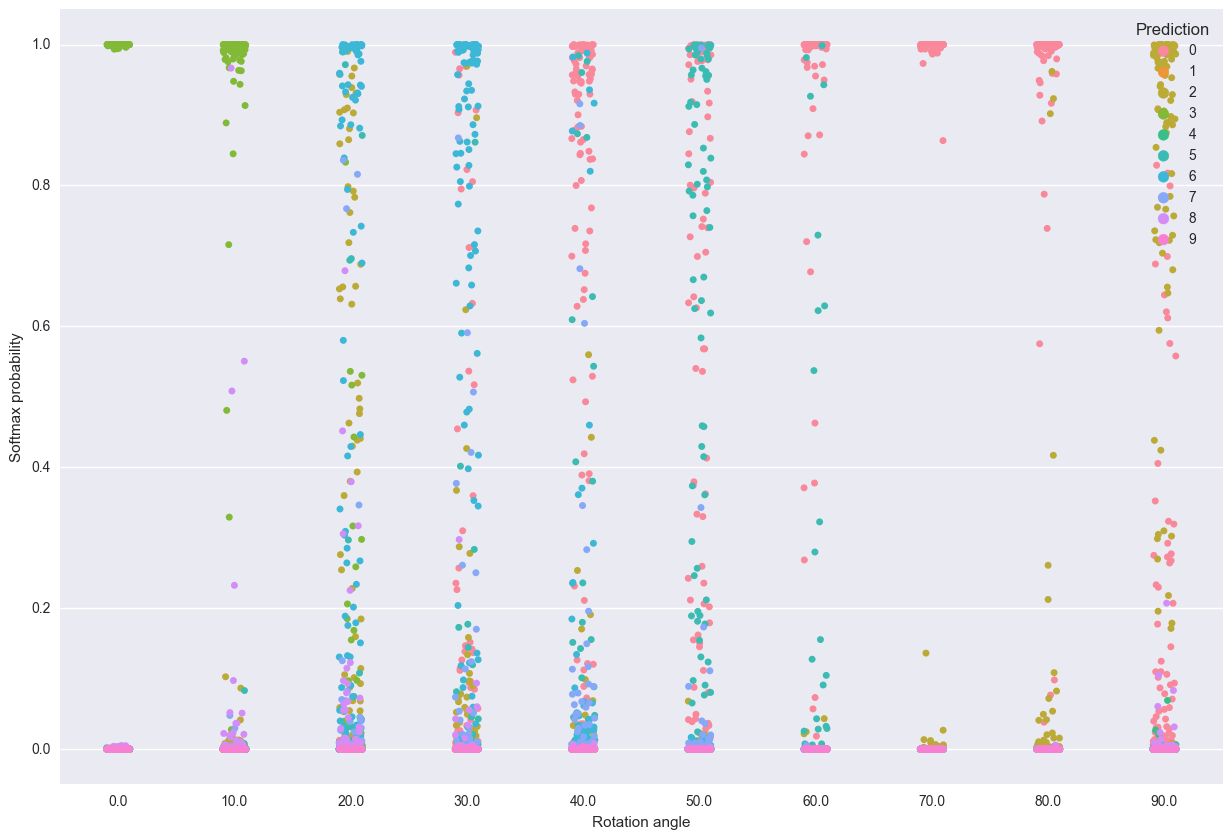

In [7]:
# plot predictive uncertainty

df['unit'] = list(range(100)) * 10 * 10
df['Prediction'] = [int(f - 1) for f in df['out']]

plt.figure(figsize=(15, 10))
sns.tsplot(df, time='angle', value='prob', condition='Prediction', unit='unit', err_style="ci_bars",
           interpolate=False)
plt.ylim(-0.05, 1.05)
plt.xticks([10 * f for f in range(10)])
sns.despine()
plt.ylabel('Softmax probability')
plt.xlabel('Rotation angle')
legend = plt.legend(loc=0, title='Prediction')
plt.show()

plt.figure(figsize=(15, 10))
sns.stripplot(data=df, x='angle', y='prob', hue='Prediction', jitter=True)
plt.ylim(-0.05, 1.05)
plt.ylabel('Softmax probability')
plt.xlabel('Rotation angle')
legend = plt.legend(loc=0, title='Prediction')
plt.show()